In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") 
 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler


train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
sample_submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [2]:
train.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Ford, Mr. William Neal",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
### Null values in TRAIN
train.isnull().sum()/train.isnull().count()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

- Age has %19.83 missing values
- Cabin has %77.1 missing values
- Embarked has only %0.22 missing values

In [5]:
### Null values in TEST
test.isnull().sum()/test.isnull().count()

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64

- Age has %20.57 missing values
- Cabin has %78.2 missing values
- Embarked has only %0.23 missing values

## SURVIVED

Percent of Survived
0    0.616162
1    0.383838
Name: PassengerId, dtype: float64


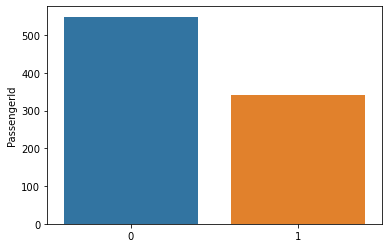

In [6]:
sns.barplot(train['Survived'].unique(), train.groupby(['Survived'])['PassengerId'].count());
print('Percent of' ,train.groupby(['Survived'])['PassengerId'].count()/ train['PassengerId'].count())

#### We have %38.4 survival rate

In [7]:
### I will add a counter to train set in order to ease ploting features
train['total_count'] = 1

## Pclass

,Pclass,Survived,total_count
0,1,0,0.089787
1,1,1,0.152637
2,2,0,0.108866
3,2,1,0.097643
4,3,0,0.417508
5,3,1,0.133558


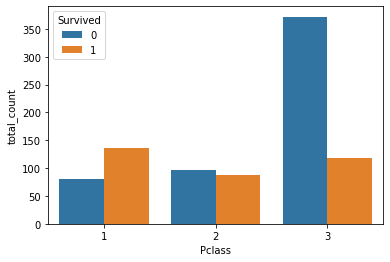

In [8]:
sns.barplot(data = pd.DataFrame(train.groupby(['Pclass','Survived'])['total_count'].count()).reset_index()
            , x = 'Pclass',y='total_count', hue = 'Survived');
pd.DataFrame(train.groupby(['Pclass','Survived'])['total_count'].count()
             /train['total_count'].sum()).reset_index().rename(columns={'train': '% of Total Survived'})

#### While *Pclass* might seem important, having a low-numbered class might mean getting off from ship somehow easier

## Name

In [9]:
train.Name.nunique()

891

In [10]:
### Since every passenger has a unique Name, we can only extract their titles
train['Title'] = train['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
test['Title'] = test['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

In [11]:
train.groupby('Title')['PassengerId'].count()

Title
Capt              1
Col               2
Don               1
Dr                7
Jonkheer          1
Lady              1
Major             2
Master           40
Miss            182
Mlle              2
Mme               1
Mr              517
Mrs             125
Ms                1
Rev               6
Sir               1
the Countess      1
Name: PassengerId, dtype: int64

In [12]:
test.groupby('Title')['PassengerId'].count()

Title
Col         2
Dona        1
Dr          1
Master     21
Miss       78
Mr        240
Mrs        72
Ms          1
Rev         2
Name: PassengerId, dtype: int64

#### Create a group for least occuring titles

In [13]:
train['Title'] = train['Title'].replace(['Capt','Col','Don','Dr','Jonkheer','Lady','Major' 
                                         ,'Mlle','Mme','Ms','Rev','Sir','the Countess','Dona'], 'Others')
test['Title'] = test['Title'].replace(['Capt','Col','Don','Dr','Jonkheer','Lady','Major' 
                                         ,'Mlle','Mme','Ms','Rev','Sir','the Countess','Dona'], 'Others')

,Survived
Title,
Master,0.575000
Miss,0.697802
Mr,0.156673
Mrs,0.792000
Others,0.444444


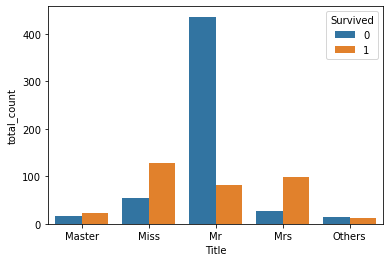

In [14]:
sns.barplot(data = pd.DataFrame(train.groupby(['Title','Survived'])['total_count'].count()).reset_index()
            , x = 'Title',y='total_count', hue = 'Survived');
pd.DataFrame(train.groupby('Title')['Survived'].mean())

#### There are some passenger with pseudonym lets flag these passengers

In [15]:
has_pseudonym = []
for i in range(len(train)):
    name = train['Name'][i]
    if ')' in name:
        has_pseudonym.append(1)
    else:
        has_pseudonym.append(0)
        
train['has_pseudonym'] = has_pseudonym

has_pseudonym
0    0.310160
1    0.769231
Name: Survived, dtype: float64


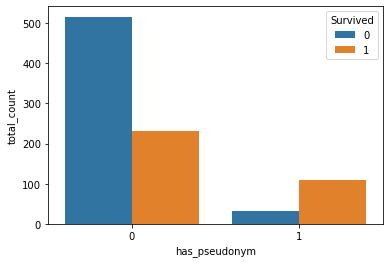

In [16]:
sns.barplot(data = pd.DataFrame(train.groupby(['has_pseudonym','Survived'])['total_count'].count()).reset_index()
            , x = 'has_pseudonym',y='total_count', hue = 'Survived');
print(train.groupby(['has_pseudonym'])['Survived'].mean())

#### Having pseudonym increase the survival rate

In [17]:
has_pseudonym = []
for i in range(len(test)):
    name = test['Name'][i]
    if ')' in name:
        has_pseudonym.append(1)
    else:
        has_pseudonym.append(0)
        
test['has_pseudonym'] = has_pseudonym

## Sex

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


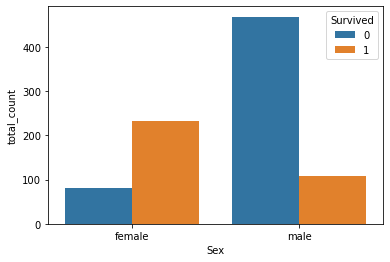

In [18]:
sns.barplot(data = pd.DataFrame(train.groupby(['Sex','Survived'])['total_count'].count()).reset_index()
            , x = 'Sex',y='total_count', hue = 'Survived');
print(train.groupby(['Sex'])['Survived'].mean())

#### Chance of females' survival much more than males

In [19]:
### Encoding Sex column 
train['Sex'] = train['Sex'].replace({"female" : 1, "male" : 0})
test['Sex'] = test['Sex'].replace({"female" : 1, "male" : 0})

## Age

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

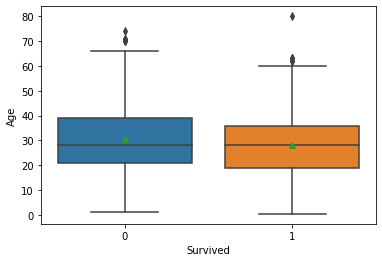

In [20]:
sns.boxplot(x=train.Survived,y=train.Age, showmeans=True);
train.Age.describe()

In [21]:
Q1 = train['Age'].quantile(0.25) 
Q3 = train['Age'].quantile(0.75) 
IQR = Q3 - Q1 
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
print('lower :',lower , 'upper :', upper)
print('Possible Number of Outliers For Age Column'
      ,train[(train['Age'] <lower) | (train['Age']  > upper)]['total_count'].sum())

lower : -6.6875 upper : 64.8125
Possible Number of Outliers For Age Column 11


In [22]:
train[train['Age']  > upper]['Survived']

33     0
54     0
96     0
116    0
280    0
456    0
493    0
630    1
672    0
745    0
851    0
Name: Survived, dtype: int64

#### Only 1 out of 11 passengers who is older than 65 is survived therefore we can simply exclude them

In [23]:
train = train[(train['Age']  < 65) | (train['Age'].isnull())]

#### Filling null Age values with median of Pclass and Sex columns

In [24]:
train.groupby(['Pclass','Sex'])['Age'].median()

Pclass  Sex
1       0      39.0
        1      35.0
2       0      30.0
        1      28.0
3       0      25.0
        1      21.5
Name: Age, dtype: float64

In [25]:
train['Age'] = np.where((train.Age.isnull())&(train.Pclass ==1)&(train.Sex ==0),39.0
                       ,np.where((train.Age.isnull())&(train.Pclass ==1)&(train.Sex ==1),35.0
                                ,np.where((train.Age.isnull())&(train.Pclass ==2)&(train.Sex ==0),30.0
                                         ,np.where((train.Age.isnull())&(train.Pclass ==2)&(train.Sex ==1),28.0
                                                  ,np.where((train.Age.isnull())&(train.Pclass ==3)&(train.Sex ==0),25.0
                                                            ,np.where((train.Age.isnull())&(train.Pclass ==3)&(train.Sex ==1)
                                                                      ,21.5,train.Age))))))

In [26]:
test.groupby(['Pclass','Sex'])['Age'].median()

Pclass  Sex
1       0      42.0
        1      41.0
2       0      28.0
        1      24.0
3       0      24.0
        1      22.0
Name: Age, dtype: float64

In [27]:
test['Age'] = np.where((test.Age.isnull())&(test.Pclass ==1)&(test.Sex ==0),42.0
                       ,np.where((test.Age.isnull())&(test.Pclass ==1)&(test.Sex ==1),41.0
                                ,np.where((test.Age.isnull())&(test.Pclass ==2)&(test.Sex ==0),28.0
                                         ,np.where((test.Age.isnull())&(test.Pclass ==2)&(test.Sex ==1),24.0
                                                  ,np.where((test.Age.isnull())&(test.Pclass ==3)&(test.Sex ==0),24.0
                                                            ,np.where((test.Age.isnull())&(test.Pclass ==3)&(test.Sex ==1)
                                                                      ,22.0,test.Age))))))

#### Creating a Age group with 10 bins which founded to be highest correlated from 1 to 15

In [28]:
label_list = list(range(1,11))
train['Age_group'] = pd.qcut(train['Age'], 10,labels = label_list)
test['Age_group'] = pd.qcut(test['Age'], 10,labels = label_list)
train['Age_group'] = train['Age_group'].astype('int')
test['Age_group'] = test['Age_group'].astype('int')
train[['Age_group','Survived']].corr()

,Age_group,Survived
Age_group,1.000000,0.001276
Survived,0.001276,1.000000


## SibSp

In [29]:
train.groupby('SibSp')['Survived'].describe()

,count,mean,std,min,25%,50%,75%,max
SibSp,,,,,,,,
0,598.0,0.349498,0.477211,0.0,0.0,0.0,1.00,1.0
1,208.0,0.538462,0.499721,0.0,0.0,1.0,1.00,1.0
2,28.0,0.464286,0.507875,0.0,0.0,0.0,1.00,1.0
3,16.0,0.250000,0.447214,0.0,0.0,0.0,0.25,1.0
4,18.0,0.166667,0.383482,0.0,0.0,0.0,0.00,1.0
5,5.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0
8,7.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0


In [30]:
### Havin less SibSp increases the chance of survival, we can group them into 3 
### Having SipSp less then 3, having 3 or 4, and more then 4
train['SibSp_group'] = np.where(train.SibSp < 3,3, np.where(train.SibSp < 5,2,1))
test['SibSp_group'] = np.where(test.SibSp < 3,3, np.where(test.SibSp < 5,2,1))

SibSp_group
1    0.000000
2    0.205882
3    0.400480
Name: Survived, dtype: float64


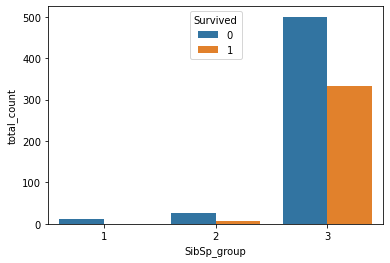

In [31]:
sns.barplot(data = pd.DataFrame(train.groupby(['SibSp_group','Survived'])['total_count'].count()).reset_index()
            , x = 'SibSp_group',y='total_count', hue = 'Survived');
print(train.groupby(['SibSp_group'])['Survived'].mean())

## Parch

#### Most of the passengers seems to have less than 2 as Parch value, therefore we can group the rest into one

In [32]:
train.groupby('Parch')['Survived'].describe()

,count,mean,std,min,25%,50%,75%,max
Parch,,,,,,,,
0,669.0,0.346786,0.476303,0.0,0.0,0.0,1.0,1.0
1,116.0,0.560345,0.498498,0.0,0.0,1.0,1.0,1.0
2,80.0,0.500000,0.503155,0.0,0.0,0.5,1.0,1.0
3,5.0,0.600000,0.547723,0.0,0.0,1.0,1.0,1.0
4,4.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
5,5.0,0.200000,0.447214,0.0,0.0,0.0,0.0,1.0
6,1.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.0


In [33]:
train['Parch'] = np.where(train.Parch > 2,3,train.Parch)
test['Parch'] = np.where(test.Parch > 2,3,test.Parch)

### Combining parent numbers with sibling numbers, family size on board can be create

In [34]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

FamilySize
1     0.306818
2     0.556250
3     0.584158
4     0.656250
5     0.190476
6     0.176471
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64


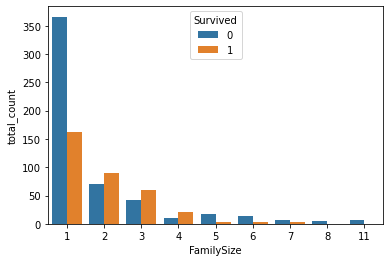

In [35]:
sns.barplot(data = pd.DataFrame(train.groupby(['FamilySize','Survived'])['total_count'].count()).reset_index()
            , x = 'FamilySize',y='total_count', hue = 'Survived');
print(train.groupby(['FamilySize'])['Survived'].mean())

In [36]:
train['FamilySize'] = np.where(train.FamilySize == 1,1
                               ,np.where(train.FamilySize <5, 2
                                         ,np.where(train.FamilySize<7,3
                                                   ,np.where(train.FamilySize == 7,4,5))))


test['FamilySize'] = np.where(test.FamilySize == 1,1
                               ,np.where(test.FamilySize <5, 2
                                         ,np.where(test.FamilySize<7,3
                                                   ,np.where(test.FamilySize == 7,4,5))))

FamilySize
1    0.306818
2    0.576792
3    0.184211
4    0.333333
5    0.000000
Name: Survived, dtype: float64


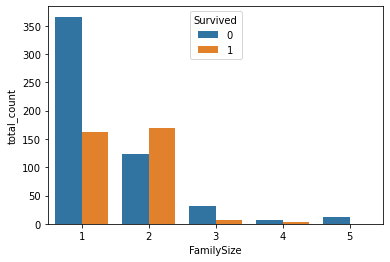

In [37]:
sns.barplot(data = pd.DataFrame(train.groupby(['FamilySize','Survived'])['total_count'].count()).reset_index()
            , x = 'FamilySize',y='total_count', hue = 'Survived');
print(train.groupby(['FamilySize'])['Survived'].mean())

## Ticket

### Lets add each Ticket len value, that might indicate possitision or class 

In [38]:
ticket_lens = []
for i in train['Ticket']:
    ticket_len = len(i)
    ticket_lens.append(ticket_len)
train['Ticket_len'] = ticket_lens


ticket_lens = []
for i in test['Ticket']:
    ticket_len = len(i)
    ticket_lens.append(ticket_len)
test['Ticket_len'] = ticket_lens

In [39]:
test.groupby('Ticket_len')['PassengerId'].count()

Ticket_len
3       2
4      47
5      62
6     183
7       9
8      42
9      11
10     22
11     10
12      6
13      9
15      3
16      2
17      2
18      8
Name: PassengerId, dtype: int64

                mean  count
Ticket_len                 
3           0.000000      2
4           0.366337    101
5           0.620155    129
6           0.322892    415
7           0.296296     27
8           0.554054     74
9           0.200000     25
10          0.358974     39
11          0.250000      8
12          0.400000     10
13          0.400000     10
15          0.333333      9
16          0.272727     11
17          0.428571     14
18          0.000000      6


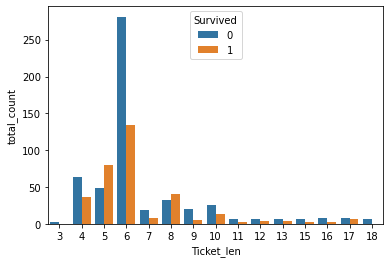

In [40]:
sns.barplot(data = pd.DataFrame(train.groupby(['Ticket_len','Survived'])['total_count'].count()).reset_index()
            , x = 'Ticket_len',y='total_count', hue = 'Survived');
print(train.groupby(['Ticket_len'])['Survived'].agg(['mean','count']))

In [41]:
## Lets group them into 3 with having similar behaviors
train['Ticket_len'] = np.where((train['Ticket_len'] == 5) | (train['Ticket_len'] == 8),3
                              ,np.where((train['Ticket_len'] == 4) | (train['Ticket_len'] == 6)| (train['Ticket_len'] == 10),2,1)) 

test['Ticket_len'] = np.where((test['Ticket_len'] == 5) | (test['Ticket_len'] == 8),1
                              ,np.where((test['Ticket_len'] == 4) | (test['Ticket_len'] == 6)| (test['Ticket_len'] == 10),2,1))

                mean  count
Ticket_len                 
1           0.286885    122
2           0.333333    555
3           0.596059    203


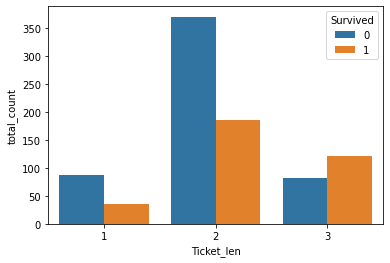

In [42]:
sns.barplot(data = pd.DataFrame(train.groupby(['Ticket_len','Survived'])['total_count'].count()).reset_index()
            , x = 'Ticket_len',y='total_count', hue = 'Survived');
print(train.groupby(['Ticket_len'])['Survived'].agg(['mean','count']))

In [43]:
train[['Ticket_len','Survived']].corr()

,Ticket_len,Survived
Ticket_len,1.00000,0.21206
Survived,0.21206,1.00000


## Fare

count    880.000000
mean      32.245439
std       49.941132
min        0.000000
25%        7.917700
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

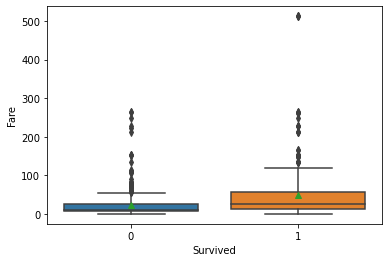

In [44]:
sns.boxplot(x=train.Survived,y=train.Fare, showmeans=True);
train.Fare.describe()

#### Let check Outliers

In [45]:
Q1 = train['Fare'].quantile(0.25) 
Q3 = train['Fare'].quantile(0.75) 
IQR = Q3 - Q1 
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
print('lower :',lower , 'upper :', upper)
print('Possible Number of Outliers For Fare Column'
      ,train[(train['Fare'] <lower) | (train['Fare']  > upper)]['total_count'].sum())

lower : -26.70575 upper : 65.62344999999999
Possible Number of Outliers For Fare Column 115


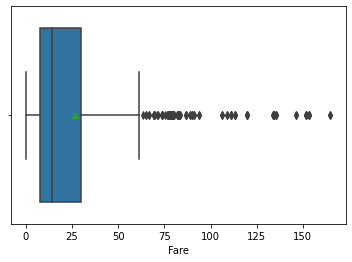

In [46]:
sns.boxplot(x=train[train.Fare < 200]['Fare'], showmeans=True);

In [47]:
train[train.Fare >= 200]['Survived'].describe()

count    20.000000
mean      0.700000
std       0.470162
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: Survived, dtype: float64

### There are 20 passenger in train who paid more than 200 who more likely to survive with %70

In [48]:
test[test.Fare > 200].describe()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,has_pseudonym,Age_group,SibSp_group,FamilySize,Ticket_len
count,18.000000,18.0,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,1056.666667,1.0,0.666667,43.805556,0.777778,0.944444,252.662506,0.333333,8.222222,2.944444,1.944444,1.222222
std,122.208116,0.0,0.485071,14.875106,0.808452,1.161754,68.649585,0.485071,2.289504,0.235702,0.802366,0.427793
min,916.000000,1.0,0.000000,13.000000,0.000000,0.000000,211.337500,0.000000,1.000000,2.000000,1.000000,1.000000
25%,962.250000,1.0,0.000000,33.125000,0.000000,0.000000,214.069800,0.000000,7.250000,3.000000,1.000000,1.000000
50%,1020.000000,1.0,1.000000,46.000000,1.000000,0.500000,237.522900,0.000000,9.000000,3.000000,2.000000,1.000000
75%,1106.000000,1.0,1.000000,56.000000,1.000000,1.750000,262.375000,1.000000,10.000000,3.000000,2.750000,1.000000
max,1299.000000,1.0,1.000000,67.000000,3.000000,3.000000,512.329200,1.000000,10.000000,3.000000,3.000000,2.000000


In [49]:
train = train[train.Fare < 200]

In [50]:
## there is not null in train Fare but there is only one in test Fare 
test.Fare.fillna(test.Fare.median(),inplace = True)

In [51]:
## Lets do same groupbing for Fare as we did in Age, and we come up with 13 bins to be the best from 1 to 15
label_list = list(range(1,14))
train['Fare_group'] = pd.qcut(train['Fare'], 13,labels = label_list)
test['Fare_group'] = pd.qcut(test['Fare'], 13,labels = label_list)
train['Fare_group'] = train['Fare_group'].astype('int')
test['Fare_group'] = test['Fare_group'].astype('int')
train[['Fare_group','Survived']].corr()

,Fare_group,Survived
Fare_group,1.000000,0.321358
Survived,0.321358,1.000000


                mean  count
Fare_group                 
1           0.142857     70
2           0.279412     68
3           0.182927     82
4           0.225806     62
5           0.163265     49
6           0.434783     92
7           0.304348     46
8           0.483333     60
9           0.470588     68
10          0.476923     65
11          0.352113     71
12          0.633333     60
13          0.776119     67


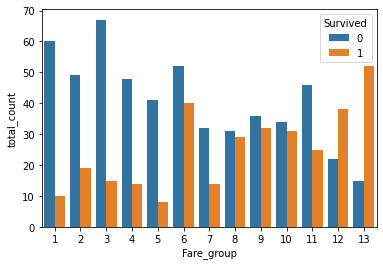

In [52]:
sns.barplot(data = pd.DataFrame(train.groupby(['Fare_group','Survived'])['total_count'].count()).reset_index()
            , x = 'Fare_group',y='total_count', hue = 'Survived');
print(train.groupby(['Fare_group'])['Survived'].agg(['mean','count']))

In [53]:
train['Fare_group_flag'] = np.where(train['Fare_group'] < 6 ,1, 2)
test['Fare_group_flag'] = np.where(test['Fare_group'] < 6 ,1, 2)
train[['Fare_group_flag','Survived']].corr()

,Fare_group_flag,Survived
Fare_group_flag,1.000000,0.294669
Survived,0.294669,1.000000


                     mean  count
Fare_group_flag                 
1                0.199396    331
2                0.493384    529


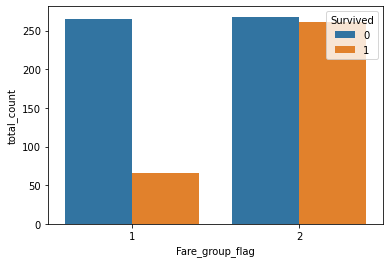

In [54]:
sns.barplot(data = pd.DataFrame(train.groupby(['Fare_group_flag','Survived'])['total_count'].count()).reset_index()
            , x = 'Fare_group_flag',y='total_count', hue = 'Survived');
print(train.groupby(['Fare_group_flag'])['Survived'].agg(['mean','count']))

## Cabin

In [55]:
train['Cabin'] = train['Cabin'].str[0]
train['Cabin'] = np.where(train['Cabin'].isnull(),'No_Cabin',train['Cabin'])
test['Cabin'] = test['Cabin'].str[0]
test['Cabin'] = np.where(test['Cabin'].isnull(),'No_Cabin',test['Cabin'])

Cabin
A           0.461538
B           0.750000
C           0.607843
D           0.757576
E           0.774194
F           0.615385
G           0.500000
No_Cabin    0.300885
T           0.000000
Name: Survived, dtype: float64


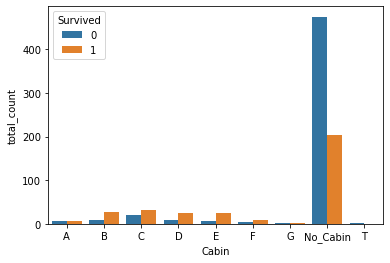

In [56]:
sns.barplot(data = pd.DataFrame(train.groupby(['Cabin','Survived'])['total_count'].sum()).reset_index()
            , x = 'Cabin',y='total_count', hue = 'Survived');
print(train.groupby(['Cabin'])['Survived'].mean())

#### It is clear that passengers in cabin B,C,D,E even F has more survival chance than others, lets flag this

In [57]:
### There is only one with Cabin =  T
train = train[train['Cabin'] != 'T']

In [58]:
train['Cabin_group'] = np.where((train['Cabin'] == 'A') | (train['Cabin'] == 'G') | (train['Cabin'] == 'No_Cabin'),0,1)

test['Cabin_group'] = np.where((test['Cabin'] == 'A') | (test['Cabin'] == 'G') | (test['Cabin'] == 'No_Cabin'),0,1)

In [59]:
train[['Cabin_group','Survived']].corr()

,Cabin_group,Survived
Cabin_group,1.000000,0.320687
Survived,0.320687,1.000000


In [60]:
train['Cabin_flag'] = np.where(train.Cabin == 'No_Cabin',0,1)
test['Cabin_flag'] = np.where(test.Cabin == 'No_Cabin',0,1)
train[['Cabin_flag','Survived']].corr()

,Cabin_flag,Survived
Cabin_flag,1.000000,0.318045
Survived,0.318045,1.000000


## Embarked

In [61]:
print('Null values in Train Embarked',train.Embarked.isnull().sum())
print('Null values in Test  Embarked',test.Embarked.isnull().sum())

Null values in Train Embarked 2
Null values in Test  Embarked 0


In [62]:
train.groupby('Embarked')['Survived'].describe()

,count,mean,std,min,25%,50%,75%,max
Embarked,,,,,,,,
C,153.0,0.549020,0.499225,0.0,0.0,1.0,1.0,1.0
Q,75.0,0.400000,0.493197,0.0,0.0,0.0,1.0,1.0
S,629.0,0.335453,0.472524,0.0,0.0,0.0,1.0,1.0


There were only 2 null value in train Embarked column, I will fill them with most occured one which is 'S'. There were non null in test

In [63]:
train.Embarked.fillna('S',inplace = True)

## Correlation

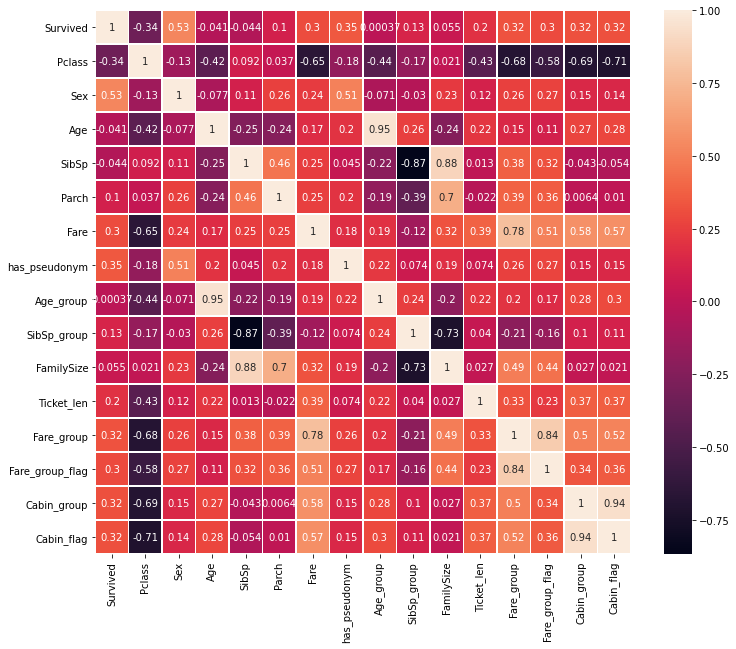

In [64]:
plt.subplots(figsize=(12,10))
sns.heatmap(train.drop(columns = ['PassengerId','total_count']).corr(), annot=True, linewidths=.5);

- Most important features are : Sex, has_pseudonym,Cabin_flag,Fare and Pclass 
- As expected FamilySize, SibSp and Parch are highly correlated

In [65]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'total_count', 'Title',
       'has_pseudonym', 'Age_group', 'SibSp_group', 'FamilySize', 'Ticket_len',
       'Fare_group', 'Fare_group_flag', 'Cabin_group', 'Cabin_flag'],
      dtype='object')

In [66]:
train = pd.get_dummies(data=train,columns=['Pclass','Embarked','Title','Cabin','FamilySize'],drop_first=True)
test = pd.get_dummies(data=test,columns=['Pclass','Embarked','Title','Cabin','FamilySize'],drop_first=True)

In [67]:
features = train.drop(columns = ['PassengerId', 'Survived', 'Name', 'Ticket','total_count']).columns

In [68]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_ = train[features]
y = train.Survived
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2,random_state =1)

sc = MinMaxScaler()
sc.fit(X_train)

X = sc.transform(train[features])

X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

X_preds = sc.transform(test[features])
print(X.shape)
print(y.shape)
print(X_preds.shape)

(859, 32)
(859,)
(418, 32)


In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state =1 )
lgr = LogisticRegression()

lgr.fit(X_train,y_train)
y_pred = lgr.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {}".format(accuracy))
confusion_matrix(y_test, y_pred)

Accuracy: 0.8023255813953488


array([[85, 14],
       [20, 53]])

In [70]:
results = lgr.predict(X_preds)
sample_submission['Survived'] = results

In [71]:
sample_submission.to_csv('pred.csv', index=False)